# Imports 

In [18]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Preparing Data

In [19]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((500, 500)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])


test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((500, 500)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])


train_dataset = datasets.ImageFolder(
    '/kaggle/input/chest-xray/data',  
    transform=train_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=10,  
    shuffle=True,  
    num_workers=4  
)


test_dataset = datasets.ImageFolder(
    '/kaggle/input/chest-xray/test_data',  
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=10, 
    shuffle=False,  
    num_workers=4  
)


# Model

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)      
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1) 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) 
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # Input: (500, 500)
        # After Pooling: (250, 250)
        # After 2nd Pooling: (125, 125)
        # After 3rd Pooling: (62, 62)
        # After 4th Pooling: (31, 31)
        self.fc1 = nn.Linear(64 * 31 * 31, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

# Compute Class Weight 

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_labels = []
for _, target in train_loader:
    all_labels.extend(target.numpy())

class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
pos_weight = class_weights[0] / class_weights[1]

print(class_weights)
print(pos_weight)

tensor([1.3959, 0.7790], device='cuda:0')
tensor(1.7919, device='cuda:0')


# Training and Evaluating 

In [30]:
model = Net()
criterion = nn.BCEWithLogitsLoss(weight=pos_weight)  
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=61504, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [31]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [32]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).float()  
        optimizer.zero_grad()
        output = model(data).squeeze(1)  
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        pred = torch.round(torch.sigmoid(output)) 
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f'\nTraining set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.0f}%)\n')
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

In [33]:
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device).float()  
            output = model(data).squeeze(1)  
            
            loss = criterion(output, target)
            val_loss += loss.item()
            
            pred = torch.round(torch.sigmoid(output))  
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct / total
    print(f'\nValidation set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.0f}%)\n')
    val_losses.append(avg_loss)
    val_accuracies.append(accuracy)

In [34]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    validate(model, device, test_loader) 

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/550 (0%)]	Loss: 1.268968
Train Epoch: 1 [100/550 (18%)]	Loss: 1.181296
Train Epoch: 1 [200/550 (36%)]	Loss: 1.111246
Train Epoch: 1 [300/550 (55%)]	Loss: 1.010643
Train Epoch: 1 [400/550 (73%)]	Loss: 1.227715
Train Epoch: 1 [500/550 (91%)]	Loss: 0.912325

Training set: Average loss: 1.1655, Accuracy: 348/550 (63%)


Validation set: Average loss: 1.2102, Accuracy: 37/74 (50%)

Train Epoch: 2 [0/550 (0%)]	Loss: 1.045522
Train Epoch: 2 [100/550 (18%)]	Loss: 0.681368
Train Epoch: 2 [200/550 (36%)]	Loss: 0.509505
Train Epoch: 2 [300/550 (55%)]	Loss: 1.030176
Train Epoch: 2 [400/550 (73%)]	Loss: 1.362355
Train Epoch: 2 [500/550 (91%)]	Loss: 0.560619

Training set: Average loss: 0.8445, Accuracy: 436/550 (79%)


Validation set: Average loss: 0.4673, Accuracy: 68/74 (92%)

Train Epoch: 3 [0/550 (0%)]	Loss: 0.342304
Train Epoch: 3 [100/550 (18%)]	Loss: 0.839192
Train Epoch: 3 [200/550 (36%)]	Loss: 1.447536
Train Epoch: 3 [300/550 (55%)]	Loss: 0.551759
Train Epoch: 3 [400/550 (

# Plots

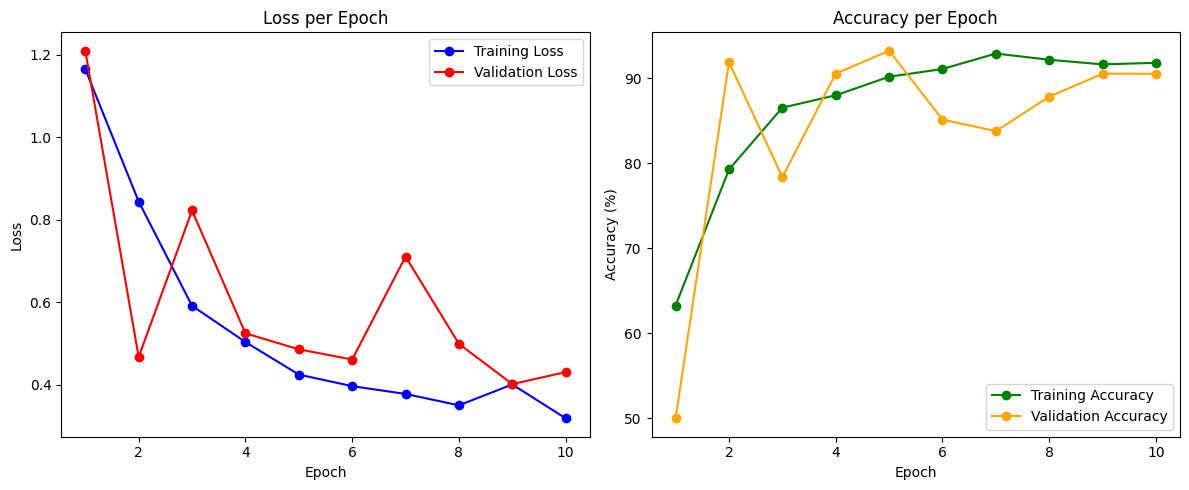

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', linestyle='-', color='g', label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', linestyle='-', color='orange', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# Save the Model

In [36]:
torch.save(model.state_dict(), "chestxray_cnn.pt")